<a href="https://colab.research.google.com/github/SeongminCC/nongnet_AI/blob/main/modeling_2weeks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
print(sys.version)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LSTM   # LSTM 층 
from sklearn.model_selection import train_test_split
import random
import os


# 경고 끄기
warnings.filterwarnings(action='ignore')

# 시드고정
tf.random.set_seed(19970119)
random.seed(19970119)
np.random.seed(19970119)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/DNA/농넷_AIFactory/aT_data
!ls -al

/content/drive/MyDrive/DNA/농넷_AIFactory/aT_data
total 5216
-rw------- 1 root root   21765 Aug 28 08:31 answer_example.csv
-rw------- 1 root root 4737091 Sep  5 06:04 aT_베이스라인.ipynb
drwx------ 2 root root    4096 Sep  4 13:59 aT_test_raw
drwx------ 2 root root    4096 Sep  4 13:59 aT_train_raw
drwx------ 2 root root    4096 Sep  4 13:59 data
-rw------- 1 root root  552825 Sep 12 04:09 modeling.ipynb
-rw------- 1 root root   15743 Aug 28 12:05 preprocessing.py


# 학습할 데이터 불러오기

- 전처리가 끝난 데이터를 가져옴
  - 품목 하나에 대해서만 학습

In [23]:
df1 = pd.read_csv('./data/train/train_0.csv')
df1

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,월구분_12월,월구분_1월,월구분_2월,월구분_3월,월구분_4월,월구분_5월,월구분_6월,월구분_7월,월구분_8월,월구분_9월
0,20130101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
1,20130102,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,0,1,0,0,0,0,0,0,0,0
2,20130103,1898.10,48.0,91108.8,1.0,230001.0,23000102.0,800.0,3401.863678,541.0,...,0,1,0,0,0,0,0,0,0,0
3,20130104,8488.48,120.0,1019018.0,3.0,230001.0,23000101.0,323.0,6553.903226,279.0,...,0,1,0,0,0,0,0,0,0,0
4,20130105,3556.44,540.0,1921077.0,4.0,371501.0,37150102.0,742.0,4299.079157,1233.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,20161227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
1457,20161228,2752.75,60.0,164835.0,4.0,230001.0,23000104.0,800.0,6128.845893,1595.0,...,1,0,0,0,0,0,0,0,0,0
1458,20161229,10010.00,18.0,180180.0,1.0,230003.0,23000303.0,225.0,6644.034096,437.0,...,1,0,0,0,0,0,0,0,0,0
1459,20161230,11411.40,4.0,45645.6,1.0,350301.0,35030101.0,570.0,6572.480795,972.0,...,1,0,0,0,0,0,0,0,0,0


# nan 제거

- 시계열 데이터이므로 결측치 기준 전과 후의 데이터를 그대로 복사


In [24]:
df2 = df1.fillna(method='ffill') # 결측치 위치 기준 윗 값 가져오기 
df2 = df1.fillna(method='bfill') # 결측치 위치 기준 아랫 값 가져오기

df2

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,월구분_12월,월구분_1월,월구분_2월,월구분_3월,월구분_4월,월구분_5월,월구분_6월,월구분_7월,월구분_8월,월구분_9월
0,20130101,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,0,1,0,0,0,0,0,0,0,0
1,20130102,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,0,1,0,0,0,0,0,0,0,0
2,20130103,1898.10,48.0,91108.8,1.0,230001.0,23000102.0,800.0,3401.863678,541.0,...,0,1,0,0,0,0,0,0,0,0
3,20130104,8488.48,120.0,1019018.0,3.0,230001.0,23000101.0,323.0,6553.903226,279.0,...,0,1,0,0,0,0,0,0,0,0
4,20130105,3556.44,540.0,1921077.0,4.0,371501.0,37150102.0,742.0,4299.079157,1233.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,20161227,2752.75,60.0,164835.0,4.0,230001.0,23000104.0,800.0,6128.845893,1595.0,...,1,0,0,0,0,0,0,0,0,0
1457,20161228,2752.75,60.0,164835.0,4.0,230001.0,23000104.0,800.0,6128.845893,1595.0,...,1,0,0,0,0,0,0,0,0,0
1458,20161229,10010.00,18.0,180180.0,1.0,230003.0,23000303.0,225.0,6644.034096,437.0,...,1,0,0,0,0,0,0,0,0,0
1459,20161230,11411.40,4.0,45645.6,1.0,350301.0,35030101.0,570.0,6572.480795,972.0,...,1,0,0,0,0,0,0,0,0,0


2013-01-03 와 같은 형식으로 날짜 재 배열(pd.to_datetime 함수 사용)

In [25]:
date = pd.to_datetime(df1['datadate'], format='%Y%m%d')
df2['datadate'] = date 
df2.head()

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,월구분_12월,월구분_1월,월구분_2월,월구분_3월,월구분_4월,월구분_5월,월구분_6월,월구분_7월,월구분_8월,월구분_9월
0,2013-01-01,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,0,1,0,0,0,0,0,0,0,0
1,2013-01-02,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,0,1,0,0,0,0,0,0,0,0
2,2013-01-03,1898.10,48.0,91108.8,1.0,230001.0,23000102.0,800.0,3401.863678,541.0,...,0,1,0,0,0,0,0,0,0,0
3,2013-01-04,8488.48,120.0,1019018.0,3.0,230001.0,23000101.0,323.0,6553.903226,279.0,...,0,1,0,0,0,0,0,0,0,0
4,2013-01-05,3556.44,540.0,1921077.0,4.0,371501.0,37150102.0,742.0,4299.079157,1233.0,...,0,1,0,0,0,0,0,0,0,0


# 데이터프레임 재구성
**0으로 채워져있는 사용할 수 없는 열들 제거**
- X : 27개의 열들
- Y : 단가 (원)

In [26]:
df3 = df2.iloc[:, :28]
df3

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,일자별_소매가격_평균(원),일자별_소매가격_최소(원),수출중량(kg),수출금액(달러),수입중량(kg),수입금액(달러),무역수지(달러),주산지_0_초기온도(℃),주산지_0_최대온도(℃),주산지_0_최저온도(℃)
0,2013-01-01,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,-3.9,4.4,-7.7
1,2013-01-02,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,2.8,6.7,-1.1
2,2013-01-03,1898.10,48.0,91108.8,1.0,230001.0,23000102.0,800.0,3401.863678,541.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,-1.2,5.0,-6.3
3,2013-01-04,8488.48,120.0,1019018.0,3.0,230001.0,23000101.0,323.0,6553.903226,279.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,-1.7,6.8,-4.5
4,2013-01-05,3556.44,540.0,1921077.0,4.0,371501.0,37150102.0,742.0,4299.079157,1233.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,-4.6,6.2,-6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2016-12-27,2752.75,60.0,164835.0,4.0,230001.0,23000104.0,800.0,6128.845893,1595.0,...,5327.441860,3330.0,0.0,0.0,1465836.0,1154379.0,-1154379.0,-7.6,7.0,-8.1
1457,2016-12-28,2752.75,60.0,164835.0,4.0,230001.0,23000104.0,800.0,6128.845893,1595.0,...,5327.441860,3330.0,0.0,0.0,1465836.0,1154379.0,-1154379.0,1.6,9.4,-3.3
1458,2016-12-29,10010.00,18.0,180180.0,1.0,230003.0,23000303.0,225.0,6644.034096,437.0,...,5319.545455,3330.0,0.0,0.0,1465836.0,1154379.0,-1154379.0,-3.2,-1.0,-7.6
1459,2016-12-30,11411.40,4.0,45645.6,1.0,350301.0,35030101.0,570.0,6572.480795,972.0,...,5319.545455,3330.0,0.0,0.0,1465836.0,1154379.0,-1154379.0,-7.6,-7.6,-15.6


# 열 이름 확인
- train과 val으로 나누기 위함

In [27]:
df3.columns

Index(['datadate', '단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드',
       '산지코드 ', '해당일자_전체평균가격(원)', '해당일자_전체거래물량(kg)', '하위가격 평균가(원)',
       '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)',
       '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)',
       '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)',
       '무역수지(달러)', '주산지_0_초기온도(℃)', '주산지_0_최대온도(℃)', '주산지_0_최저온도(℃)'],
      dtype='object')

# 연도 열 추가

In [28]:
df3.head()

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,일자별_소매가격_평균(원),일자별_소매가격_최소(원),수출중량(kg),수출금액(달러),수입중량(kg),수입금액(달러),무역수지(달러),주산지_0_초기온도(℃),주산지_0_최대온도(℃),주산지_0_최저온도(℃)
0,2013-01-01,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,-3.9,4.4,-7.7
1,2013-01-02,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,2.8,6.7,-1.1
2,2013-01-03,1898.10,48.0,91108.8,1.0,230001.0,23000102.0,800.0,3401.863678,541.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,-1.2,5.0,-6.3
3,2013-01-04,8488.48,120.0,1019018.0,3.0,230001.0,23000101.0,323.0,6553.903226,279.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,-1.7,6.8,-4.5
4,2013-01-05,3556.44,540.0,1921077.0,4.0,371501.0,37150102.0,742.0,4299.079157,1233.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,-4.6,6.2,-6.1


# 데이터 시각화

In [29]:
import matplotlib.pylab as plt
import seaborn as sns

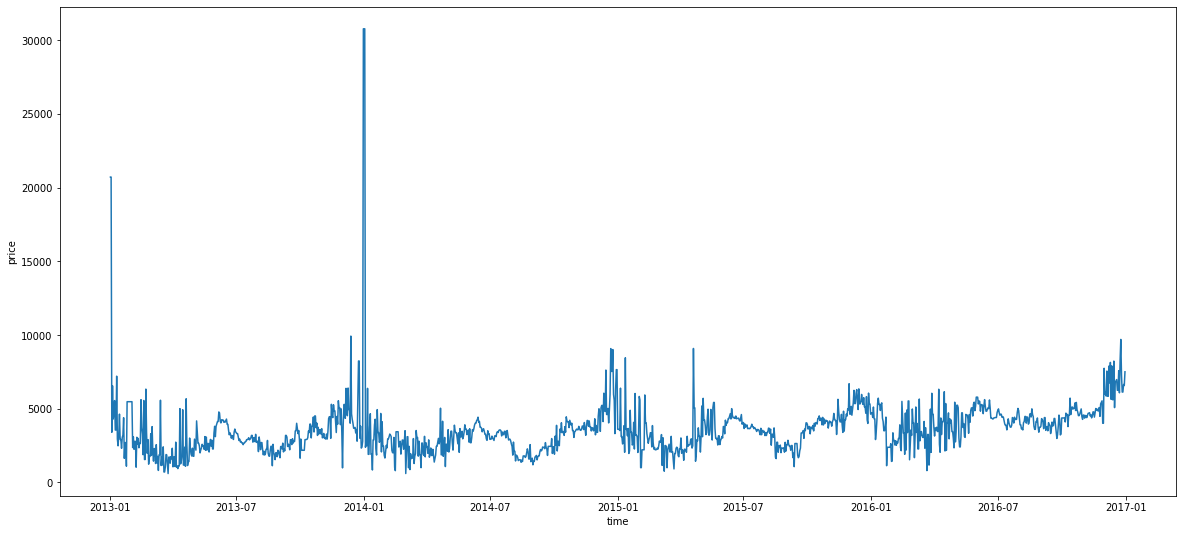

In [31]:
plt.figure(figsize = (20, 9))
sns.lineplot(x = date, y = df3['해당일자_전체평균가격(원)'])
plt.xlabel('time')
plt.ylabel('price')
plt.show()

# Normalization
- 학습이 잘 되도록 데이터를 한번 normalization(정규화) 해준다.

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드', '산지코드 ', '해당일자_전체평균가격(원)', '해당일자_전체거래물량(kg)',
              '하위가격 평균가(원)', '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)',
                '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)',
                '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)',
                '무역수지(달러)', '주산지_0_초기온도(℃)', '주산지_0_최대온도(℃)', '주산지_0_최저온도(℃)']
df_scaled = scaler.fit_transform(df3[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),하위가격 평균가(원),...,일자별_소매가격_평균(원),일자별_소매가격_최소(원),수출중량(kg),수출금액(달러),수입중량(kg),수입금액(달러),무역수지(달러),주산지_0_초기온도(℃),주산지_0_최대온도(℃),주산지_0_최저온도(℃)
0,0.126323,0.000198,0.001130,0.000000,0.967086,0.967086,0.717647,0.666642,0.000357,0.665472,...,0.164136,0.773585,0.0,0.0,1.00000,0.765419,0.234479,0.391473,0.345703,0.364865
1,0.126323,0.000198,0.001130,0.000000,0.967086,0.967086,0.717647,0.666642,0.000357,0.665472,...,0.164136,0.773585,0.0,0.0,1.00000,0.765419,0.234479,0.521318,0.390625,0.492278
2,0.035635,0.009309,0.010118,0.000000,0.443787,0.443787,0.788235,0.092854,0.013582,0.267436,...,0.164136,0.773585,0.0,0.0,1.00000,0.765419,0.234479,0.443798,0.357422,0.391892
3,0.176403,0.023569,0.115962,0.064516,0.443787,0.443787,0.227059,0.197334,0.006906,0.307677,...,0.164136,0.773585,0.0,0.0,1.00000,0.765419,0.234479,0.434109,0.392578,0.426641
4,0.071057,0.106754,0.218856,0.096774,0.967086,0.967086,0.720000,0.122594,0.031217,0.401915,...,0.164136,0.773585,0.0,0.0,1.00000,0.765419,0.234479,0.377907,0.380859,0.395753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0.053890,0.011685,0.018528,0.096774,0.443787,0.443787,0.788235,0.183245,0.040441,0.361351,...,0.964442,1.000000,0.0,0.0,0.72019,0.729881,0.270002,0.319767,0.396484,0.357143
1457,0.053890,0.011685,0.018528,0.096774,0.443787,0.443787,0.788235,0.183245,0.040441,0.361351,...,0.964442,1.000000,0.0,0.0,0.72019,0.729881,0.270002,0.498062,0.443359,0.449807
1458,0.208902,0.003367,0.020278,0.000000,0.443794,0.443794,0.111765,0.200322,0.010932,0.562846,...,0.958300,1.000000,0.0,0.0,0.72019,0.729881,0.270002,0.405039,0.240234,0.366795
1459,0.238836,0.000594,0.004933,0.000000,0.888683,0.888683,0.517647,0.197950,0.024566,0.524421,...,0.958300,1.000000,0.0,0.0,0.72019,0.729881,0.270002,0.319767,0.111328,0.212355


# 데이터셋 생성

In [57]:
TEST_SIZE = 14  # 2주간 데이터 예측

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [68]:
def make_dataset(data, label, window_size=4):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [71]:
feature_cols = ['단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드', '산지코드 ', '해당일자_전체거래물량(kg)',
                '하위가격 평균가(원)', '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)',
                '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)',
                '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)',
                '무역수지(달러)', '주산지_0_초기온도(℃)', '주산지_0_최대온도(℃)', '주산지_0_최저온도(℃)']
label_cols = ['해당일자_전체평균가격(원)']

train_feature = train[feature_cols]
train_label = train[label_cols]

test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((1154, 4, 26), (289, 4, 26))

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label)
test_feature.shape, test_label.shape
# ((10, 4, 26), (10, 1))

((10, 4, 26), (10, 1))

# LSTM 모델 생성

In [72]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from tensorflow.keras import optimizers



model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False))
model.add(Dense(1))

In [73]:
model_path = '/content/drive/MyDrive/DNA/농넷_AIFactory'


model.compile(loss='mean_squared_error', 
              optimizer=optimizers.Adam(lr=1e-4, 
                                        beta_1=0.9, 
                                        beta_2=0.999, 
                                        decay=1e-6))



early_stop = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss)
                           patience=10)   # 10회 Epoch동안 개선되지 않는다면 종료


filename = os.path.join(model_path, 'tmp_checkpoint.h10')

checkpoint = ModelCheckpoint(filename,  # 파일명 지정
                             monitor='val_loss', # val_loss 값이 개선되었을때 호출
                             verbose=1,  # 로그를 출력
                             save_best_only=True,   # 가장 best 값만 저장
                             mode='auto')     # auto는 알아서 best를 찾는다. min/max


history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
71/73 [============================>.] - ETA: 0s - loss: 0.0252
Epoch 1: val_loss improved from inf to 0.01432, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 3s 30ms/step - loss: 0.0250 - val_loss: 0.0143
Epoch 2/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0109
Epoch 2: val_loss improved from 0.01432 to 0.01077, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 3/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0088
Epoch 3: val_loss improved from 0.01077 to 0.00920, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0086 - val_loss: 0.0092
Epoch 4/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0065
Epoch 4: val_loss improved from 0.00920 to 0.00784, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0071 - val_loss: 0.0078
Epoch 5/200
64/73 [=========================>....] - ETA: 0s - loss: 0.0061
Epoch 5: val_loss improved from 0.00784 to 0.00679, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 32ms/step - loss: 0.0059 - val_loss: 0.0068
Epoch 6/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0052
Epoch 6: val_loss improved from 0.00679 to 0.00606, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0051 - val_loss: 0.0061
Epoch 7/200
73/73 [==============================] - ETA: 0s - loss: 0.0045
Epoch 7: val_loss improved from 0.00606 to 0.00557, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 8/200
72/73 [============================>.] - ETA: 0s - loss: 0.0042
Epoch 8: val_loss improved from 0.00557 to 0.00525, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0042 - val_loss: 0.0052
Epoch 9/200
71/73 [============================>.] - ETA: 0s - loss: 0.0039
Epoch 9: val_loss improved from 0.00525 to 0.00501, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 32ms/step - loss: 0.0039 - val_loss: 0.0050
Epoch 10/200
72/73 [============================>.] - ETA: 0s - loss: 0.0038
Epoch 10: val_loss improved from 0.00501 to 0.00483, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 11/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0037
Epoch 11: val_loss improved from 0.00483 to 0.00470, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0036 - val_loss: 0.0047
Epoch 12/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0036
Epoch 12: val_loss improved from 0.00470 to 0.00457, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 32ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 13/200
71/73 [============================>.] - ETA: 0s - loss: 0.0034
Epoch 13: val_loss improved from 0.00457 to 0.00451, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0034 - val_loss: 0.0045
Epoch 14/200
70/73 [===========================>..] - ETA: 0s - loss: 0.0034
Epoch 14: val_loss improved from 0.00451 to 0.00443, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 15/200
70/73 [===========================>..] - ETA: 0s - loss: 0.0033
Epoch 15: val_loss improved from 0.00443 to 0.00432, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 16/200
71/73 [============================>.] - ETA: 0s - loss: 0.0032
Epoch 16: val_loss improved from 0.00432 to 0.00426, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 17/200
61/73 [========================>.....] - ETA: 0s - loss: 0.0034
Epoch 17: val_loss improved from 0.00426 to 0.00419, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 18/200
69/73 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 18: val_loss improved from 0.00419 to 0.00414, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 19/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0024
Epoch 19: val_loss improved from 0.00414 to 0.00410, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 20/200
64/73 [=========================>....] - ETA: 0s - loss: 0.0032
Epoch 20: val_loss improved from 0.00410 to 0.00406, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 21/200
71/73 [============================>.] - ETA: 0s - loss: 0.0030
Epoch 21: val_loss improved from 0.00406 to 0.00400, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 22/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0030
Epoch 22: val_loss improved from 0.00400 to 0.00396, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 23/200
69/73 [===========================>..] - ETA: 0s - loss: 0.0029
Epoch 23: val_loss improved from 0.00396 to 0.00393, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 27ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 24/200
70/73 [===========================>..] - ETA: 0s - loss: 0.0029
Epoch 24: val_loss improved from 0.00393 to 0.00390, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 25/200
73/73 [==============================] - ETA: 0s - loss: 0.0028
Epoch 25: val_loss improved from 0.00390 to 0.00387, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 26/200
72/73 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 26: val_loss improved from 0.00387 to 0.00383, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 27/200
71/73 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 27: val_loss improved from 0.00383 to 0.00381, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 32ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 28/200
70/73 [===========================>..] - ETA: 0s - loss: 0.0028
Epoch 28: val_loss improved from 0.00381 to 0.00376, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 29/200
71/73 [============================>.] - ETA: 0s - loss: 0.0027
Epoch 29: val_loss did not improve from 0.00376
73/73 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 30/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0028
Epoch 30: val_loss did not improve from 0.00376
73/73 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 31/200
72/73 [============================>.] - ETA: 0s - loss: 0.0027
Epoch 31: val_loss improved from 0.00376 to 0.00369, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 32/200
70/73 [===========================>..] - ETA: 0s - loss: 0.0027
Epoch 32: val_loss improved from 0.00369 to 0.00367, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 33/200
71/73 [============================>.] - ETA: 0s - loss: 0.0026
Epoch 33: val_loss improved from 0.00367 to 0.00365, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 34/200
69/73 [===========================>..] - ETA: 0s - loss: 0.0027
Epoch 34: val_loss improved from 0.00365 to 0.00363, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 35/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0027
Epoch 35: val_loss did not improve from 0.00363
73/73 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 36/200
72/73 [============================>.] - ETA: 0s - loss: 0.0026
Epoch 36: val_loss improved from 0.00363 to 0.00359, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 31ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 37/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0027
Epoch 37: val_loss improved from 0.00359 to 0.00356, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 4s 57ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 38/200
71/73 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 38: val_loss improved from 0.00356 to 0.00355, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 39/200
71/73 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 39: val_loss improved from 0.00355 to 0.00353, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 40/200
72/73 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 40: val_loss improved from 0.00353 to 0.00351, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 27ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 41/200
72/73 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 41: val_loss improved from 0.00351 to 0.00350, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 42/200
71/73 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 42: val_loss improved from 0.00350 to 0.00349, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 43/200
62/73 [========================>.....] - ETA: 0s - loss: 0.0019
Epoch 43: val_loss improved from 0.00349 to 0.00348, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 44/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0025
Epoch 44: val_loss improved from 0.00348 to 0.00348, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 45/200
72/73 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 45: val_loss improved from 0.00348 to 0.00346, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 46/200
64/73 [=========================>....] - ETA: 0s - loss: 0.0026
Epoch 46: val_loss improved from 0.00346 to 0.00343, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 47/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0025
Epoch 47: val_loss improved from 0.00343 to 0.00343, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 48/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0025
Epoch 48: val_loss improved from 0.00343 to 0.00341, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 32ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 49/200
71/73 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 49: val_loss did not improve from 0.00341
73/73 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 50/200
72/73 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 50: val_loss did not improve from 0.00341
73/73 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 51/200
70/73 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 51: val_loss improved from 0.00341 to 0.00338, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 52/200
70/73 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 52: val_loss improved from 0.00338 to 0.00337, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 27ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 53/200
69/73 [===========================>..] - ETA: 0s - loss: 0.0017
Epoch 53: val_loss improved from 0.00337 to 0.00336, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 54/200
70/73 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 54: val_loss improved from 0.00336 to 0.00335, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 32ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 55/200
63/73 [========================>.....] - ETA: 0s - loss: 0.0026
Epoch 55: val_loss improved from 0.00335 to 0.00334, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 56/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0018
Epoch 56: val_loss did not improve from 0.00334
73/73 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 57/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0024
Epoch 57: val_loss did not improve from 0.00334
73/73 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 58/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0025
Epoch 58: val_loss did not improve from 0.00334
73/73 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 59/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0025    
Epoch 59: val_loss improved from 0.00334 to 0.00331, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 27ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 60/200
64/73 [=========================>....] - ETA: 0s - loss: 0.0025
Epoch 60: val_loss improved from 0.00331 to 0.00330, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 61/200
71/73 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 61: val_loss did not improve from 0.00330
73/73 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 62/200
70/73 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 62: val_loss improved from 0.00330 to 0.00328, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 63/200
69/73 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 63: val_loss did not improve from 0.00328
73/73 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 64/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0024
Epoch 64: val_loss did not improve from 0.00328
73/73 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 65/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0025
Epoch 65: val_loss improved from 0.00328 to 0.00327, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 66/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0025
Epoch 66: val_loss did not improve from 0.00327
73/73 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 67/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0024
Epoch 67: val_loss improved from 0.00327 to 0.00326, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 68/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0024
Epoch 68: val_loss did not improve from 0.00326
73/73 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 69/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0024
Epoch 69: val_loss improved from 0.00326 to 0.00325, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 70/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0024    
Epoch 70: val_loss did not improve from 0.00325
73/73 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 71/200
69/73 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 71: val_loss improved from 0.00325 to 0.00323, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 72/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0024
Epoch 72: val_loss did not improve from 0.00323
73/73 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 73/200
71/73 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 73: val_loss improved from 0.00323 to 0.00323, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 74/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0024
Epoch 74: val_loss did not improve from 0.00323
73/73 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 75/200
69/73 [===========================>..] - ETA: 0s - loss: 0.0023
Epoch 75: val_loss improved from 0.00323 to 0.00321, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 76/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0024
Epoch 76: val_loss improved from 0.00321 to 0.00321, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 77/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0024
Epoch 77: val_loss did not improve from 0.00321
73/73 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 78/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0024
Epoch 78: val_loss improved from 0.00321 to 0.00320, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 79/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0024
Epoch 79: val_loss improved from 0.00320 to 0.00319, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 80/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0023
Epoch 80: val_loss did not improve from 0.00319
73/73 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 81/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0024
Epoch 81: val_loss improved from 0.00319 to 0.00319, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 82/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0024
Epoch 82: val_loss did not improve from 0.00319
73/73 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 83/200
69/73 [===========================>..] - ETA: 0s - loss: 0.0023
Epoch 83: val_loss improved from 0.00319 to 0.00317, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 84/200
71/73 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 84: val_loss improved from 0.00317 to 0.00317, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 85/200
73/73 [==============================] - ETA: 0s - loss: 0.0023
Epoch 85: val_loss did not improve from 0.00317
73/73 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 86/200
70/73 [===========================>..] - ETA: 0s - loss: 0.0017
Epoch 86: val_loss improved from 0.00317 to 0.00316, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 87/200
72/73 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 87: val_loss improved from 0.00316 to 0.00316, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 32ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 88/200
61/73 [========================>.....] - ETA: 0s - loss: 0.0025
Epoch 88: val_loss did not improve from 0.00316
73/73 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 89/200
70/73 [===========================>..] - ETA: 0s - loss: 0.0023
Epoch 89: val_loss improved from 0.00316 to 0.00315, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 90/200
69/73 [===========================>..] - ETA: 0s - loss: 0.0023
Epoch 90: val_loss improved from 0.00315 to 0.00314, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 91/200
70/73 [===========================>..] - ETA: 0s - loss: 0.0023
Epoch 91: val_loss improved from 0.00314 to 0.00314, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 92/200
69/73 [===========================>..] - ETA: 0s - loss: 0.0023
Epoch 92: val_loss improved from 0.00314 to 0.00314, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 93/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0023
Epoch 93: val_loss improved from 0.00314 to 0.00313, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 94/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0023
Epoch 94: val_loss improved from 0.00313 to 0.00313, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 95/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0023
Epoch 95: val_loss improved from 0.00313 to 0.00312, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 32ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 96/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0024
Epoch 96: val_loss improved from 0.00312 to 0.00312, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 97/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0017
Epoch 97: val_loss did not improve from 0.00312
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 98/200
69/73 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 98: val_loss improved from 0.00312 to 0.00310, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 99/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0023
Epoch 99: val_loss improved from 0.00310 to 0.00309, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 100/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0023
Epoch 100: val_loss did not improve from 0.00309
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 101/200
63/73 [========================>.....] - ETA: 0s - loss: 0.0024
Epoch 101: val_loss did not improve from 0.00309
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 102/200
63/73 [========================>.....] - ETA: 0s - loss: 0.0024
Epoch 102: val_loss improved from 0.00309 to 0.00309, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 103/200
72/73 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 103: val_loss did not improve from 0.00309
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 104/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0023
Epoch 104: val_loss improved from 0.00309 to 0.00308, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 105/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0023
Epoch 105: val_loss did not improve from 0.00308
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 106/200
69/73 [===========================>..] - ETA: 0s - loss: 0.0023
Epoch 106: val_loss did not improve from 0.00308
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 107/200
64/73 [=========================>....] - ETA: 0s - loss: 0.0016
Epoch 107: val_loss improved from 0.00308 to 0.00307, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 108/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0023
Epoch 108: val_loss did not improve from 0.00307
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 109/200
70/73 [===========================>..] - ETA: 0s - loss: 0.0022
Epoch 109: val_loss did not improve from 0.00307
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 110/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0023    
Epoch 110: val_loss improved from 0.00307 to 0.00307, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 111/200
70/73 [===========================>..] - ETA: 0s - loss: 0.0022
Epoch 111: val_loss did not improve from 0.00307
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 112/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0023
Epoch 112: val_loss did not improve from 0.00307
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 113/200
69/73 [===========================>..] - ETA: 0s - loss: 0.0023
Epoch 113: val_loss did not improve from 0.00307
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 114/200
63/73 [========================>.....] - ETA: 0s - loss: 0.0023
Epoch 114: val_loss improved from 0.00307 to 0.00306, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 115/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0023
Epoch 115: val_loss improved from 0.00306 to 0.00306, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 116/200
64/73 [=========================>....] - ETA: 0s - loss: 0.0016
Epoch 116: val_loss did not improve from 0.00306
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 117/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0022
Epoch 117: val_loss did not improve from 0.00306
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 118/200
60/73 [=======================>......] - ETA: 0s - loss: 0.0024
Epoch 118: val_loss improved from 0.00306 to 0.00305, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 119/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0023
Epoch 119: val_loss improved from 0.00305 to 0.00305, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 120/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0023
Epoch 120: val_loss improved from 0.00305 to 0.00305, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 121/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0023
Epoch 121: val_loss did not improve from 0.00305
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 122/200
70/73 [===========================>..] - ETA: 0s - loss: 0.0022
Epoch 122: val_loss improved from 0.00305 to 0.00304, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 123/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0022
Epoch 123: val_loss did not improve from 0.00304
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 124/200
64/73 [=========================>....] - ETA: 0s - loss: 0.0022
Epoch 124: val_loss improved from 0.00304 to 0.00304, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 125/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0017
Epoch 125: val_loss improved from 0.00304 to 0.00304, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 126/200
62/73 [========================>.....] - ETA: 0s - loss: 0.0024
Epoch 126: val_loss improved from 0.00304 to 0.00303, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 127/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0023
Epoch 127: val_loss did not improve from 0.00303
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 128/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0023
Epoch 128: val_loss improved from 0.00303 to 0.00303, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 129/200
72/73 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 129: val_loss did not improve from 0.00303
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 130/200
69/73 [===========================>..] - ETA: 0s - loss: 0.0022
Epoch 130: val_loss did not improve from 0.00303
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 131/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0023
Epoch 131: val_loss did not improve from 0.00303
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 132/200
64/73 [=========================>....] - ETA: 0s - loss: 0.0023
Epoch 132: val_loss did not improve from 0.00303
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 133/200
58/73 [======================>.......] - E

73/73 [==============================] - 2s 28ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 134/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0023
Epoch 134: val_loss improved from 0.00302 to 0.00302, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 34ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 135/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0017
Epoch 135: val_loss did not improve from 0.00302
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 136/200
64/73 [=========================>....] - ETA: 0s - loss: 0.0022
Epoch 136: val_loss improved from 0.00302 to 0.00301, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 137/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0015
Epoch 137: val_loss improved from 0.00301 to 0.00301, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 138/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0022
Epoch 138: val_loss did not improve from 0.00301
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 139/200
63/73 [========================>.....] - ETA: 0s - loss: 0.0023    
Epoch 139: val_loss did not improve from 0.00301
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 140/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0022
Epoch 140: val_loss improved from 0.00301 to 0.00301, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 141/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0022
Epoch 141: val_loss improved from 0.00301 to 0.00300, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 142/200
62/73 [========================>.....] - ETA: 0s - loss: 0.0023
Epoch 142: val_loss improved from 0.00300 to 0.00300, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 143/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0023
Epoch 143: val_loss did not improve from 0.00300
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 144/200
61/73 [========================>.....] - ETA: 0s - loss: 0.0018
Epoch 144: val_loss improved from 0.00300 to 0.00299, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 145/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0022
Epoch 145: val_loss improved from 0.00299 to 0.00299, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 34ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 146/200
64/73 [=========================>....] - ETA: 0s - loss: 0.0023
Epoch 146: val_loss did not improve from 0.00299
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 147/200
63/73 [========================>.....] - ETA: 0s - loss: 0.0015
Epoch 147: val_loss improved from 0.00299 to 0.00298, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 148/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0016
Epoch 148: val_loss did not improve from 0.00298
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 149/200
61/73 [========================>.....] - ETA: 0s - loss: 0.0023
Epoch 149: val_loss improved from 0.00298 to 0.00298, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 150/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0022
Epoch 150: val_loss improved from 0.00298 to 0.00298, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 151/200
61/73 [========================>.....] - ETA: 0s - loss: 0.0023
Epoch 151: val_loss improved from 0.00298 to 0.00298, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 152/200
63/73 [========================>.....] - ETA: 0s - loss: 0.0022    
Epoch 152: val_loss improved from 0.00298 to 0.00298, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 153/200
62/73 [========================>.....] - ETA: 0s - loss: 0.0023
Epoch 153: val_loss did not improve from 0.00298
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 154/200
67/73 [==========================>...] - ETA: 0s - loss: 9.8573e-04
Epoch 154: val_loss did not improve from 0.00298
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 155/200
64/73 [=========================>....] - ETA: 0s - loss: 0.0018
Epoch 155: val_loss did not improve from 0.00298
73/73 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 156/200
60/73 [=======================>......] - ETA: 0s - loss: 0.0016
Epoch 156: val_loss did not improve from 0.00298
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 157/200
67/73 [==========================>...]

73/73 [==============================] - 2s 29ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 158/200
63/73 [========================>.....] - ETA: 0s - loss: 0.0023
Epoch 158: val_loss did not improve from 0.00297
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 159/200
64/73 [=========================>....] - ETA: 0s - loss: 0.0016
Epoch 159: val_loss improved from 0.00297 to 0.00296, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 33ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 160/200
63/73 [========================>.....] - ETA: 0s - loss: 0.0022
Epoch 160: val_loss improved from 0.00296 to 0.00296, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 161/200
63/73 [========================>.....] - ETA: 0s - loss: 0.0023
Epoch 161: val_loss improved from 0.00296 to 0.00295, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 30ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 162/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0021
Epoch 162: val_loss improved from 0.00295 to 0.00295, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 163/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0022
Epoch 163: val_loss did not improve from 0.00295
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 164/200
63/73 [========================>.....] - ETA: 0s - loss: 0.0022
Epoch 164: val_loss did not improve from 0.00295
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 165/200
64/73 [=========================>....] - ETA: 0s - loss: 0.0021
Epoch 165: val_loss did not improve from 0.00295
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 166/200
61/73 [========================>.....] - ETA: 0s - loss: 0.0017    
Epoch 166: val_loss did not improve from 0.00295
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 167/200
65/73 [=========================>....]

73/73 [==============================] - 2s 33ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 168/200
62/73 [========================>.....] - ETA: 0s - loss: 0.0017
Epoch 168: val_loss improved from 0.00294 to 0.00291, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 169/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0022
Epoch 169: val_loss did not improve from 0.00291
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 170/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0015    
Epoch 170: val_loss did not improve from 0.00291
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 171/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0022
Epoch 171: val_loss did not improve from 0.00291
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 172/200
63/73 [========================>.....] - ETA: 0s - loss: 0.0022
Epoch 172: val_loss did not improve from 0.00291
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 173/200
61/73 [========================>.....]

73/73 [==============================] - 2s 29ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 174/200
59/73 [=======================>......] - ETA: 0s - loss: 0.0023
Epoch 174: val_loss did not improve from 0.00291
73/73 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 175/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0022
Epoch 175: val_loss did not improve from 0.00291
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 176/200
61/73 [========================>.....] - ETA: 0s - loss: 0.0023
Epoch 176: val_loss did not improve from 0.00291
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 177/200
63/73 [========================>.....] - ETA: 0s - loss: 0.0022
Epoch 177: val_loss did not improve from 0.00291
73/73 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 178/200
65/73 [=========================>....] - E

73/73 [==============================] - 2s 33ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 182/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0021
Epoch 182: val_loss improved from 0.00291 to 0.00291, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 183/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0017
Epoch 183: val_loss did not improve from 0.00291
73/73 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 184/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0015
Epoch 184: val_loss improved from 0.00291 to 0.00291, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 185/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0021
Epoch 185: val_loss did not improve from 0.00291
73/73 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 186/200
73/73 [==============================] - ETA: 0s - loss: 0.0020
Epoch 186: val_loss improved from 0.00291 to 0.00291, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 29ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 187/200
66/73 [==========================>...] - ETA: 0s - loss: 0.0021
Epoch 187: val_loss did not improve from 0.00291
73/73 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 188/200
65/73 [=========================>....] - ETA: 0s - loss: 0.0021
Epoch 188: val_loss did not improve from 0.00291
73/73 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 189/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0021
Epoch 189: val_loss did not improve from 0.00291
73/73 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 190/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0021
Epoch 190: val_loss did not improve from 0.00291
73/73 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 191/200
63/73 [========================>.....] - E

73/73 [==============================] - 2s 33ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 192/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0020
Epoch 192: val_loss did not improve from 0.00290
73/73 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 193/200
64/73 [=========================>....] - ETA: 0s - loss: 0.0022
Epoch 193: val_loss improved from 0.00290 to 0.00290, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


73/73 [==============================] - 2s 28ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 194/200
64/73 [=========================>....] - ETA: 0s - loss: 0.0022
Epoch 194: val_loss did not improve from 0.00290
73/73 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 195/200
67/73 [==========================>...] - ETA: 0s - loss: 0.0021
Epoch 195: val_loss did not improve from 0.00290
73/73 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 196/200
68/73 [==========================>...] - ETA: 0s - loss: 0.0016    
Epoch 196: val_loss did not improve from 0.00290
73/73 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 197/200
62/73 [========================>.....] - ETA: 0s - loss: 0.0017
Epoch 197: val_loss did not improve from 0.00290
73/73 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 198/200
65/73 [=========================>....]

73/73 [==============================] - 2s 29ms/step - loss: 0.0020 - val_loss: 0.0029


**val_loss : 0.00290**

In [74]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [75]:
model.load_weights(filename)

In [76]:
pred = model.predict(test_feature)

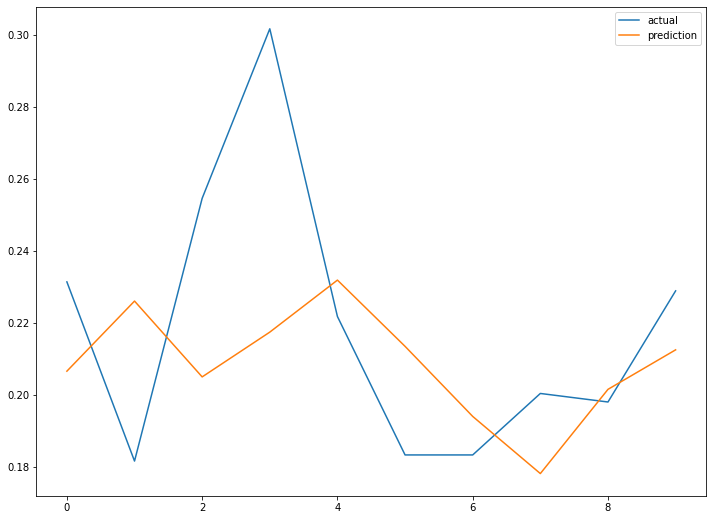

In [77]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

# 랜덤 포레스트(Random forest)
- 의사결정 트리를 랜덤하게 나온 것을 투표하여 결정하는 것 
  - 분류, 회귀에 주로 사용된다 



In [78]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score

In [79]:
clf = RandomForestRegressor()

In [88]:
# 위에서 만든 데이터셋

# x_train, y_train   : train
# x_valid, y_valid   : validation
# test_feature, test_label   : test

In [80]:
# X = df_scaled.drop(columns='해당일자_전체평균가격(원)') # '해당일자_전체평균가격(원)' column 제외
# y = df_scaled['해당일자_전체평균가격(원)']  # '해당일자_전체평균가격(원)' 예측

In [86]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

(1095,)


In [89]:
test_size = 14
X_train = df_scaled.drop(columns = '해당일자_전체평균가격(원)').iloc[:-test_size]
y_train = df_scaled['해당일자_전체평균가격(원)'].iloc[:-test_size]

X_test = df_scaled.drop(columns = '해당일자_전체평균가격(원)').iloc[-test_size:]
y_test = df_scaled['해당일자_전체평균가격(원)'].iloc[-test_size:]

In [90]:
clf.fit(X_train, y_train)

RandomForestRegressor()

In [91]:
y_pred = clf.predict(X_test)

In [92]:
mean_squared_error(y_test, y_pred)

0.0008831665401987361

val_loss : 0.0008831665401987361

# Prophet

In [93]:
!pip install pystan==2.19.1.1 --quiet
!pip install fbprophet --quiet

     |████████████████████████████████| 67.3 MB 97 kB/s 
     |████████████████████████████████| 64 kB 1.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1 requires cmdstanpy>=1.0.1, but you have cmdstanpy 0.9.5 which is incompatible.


In [94]:
from fbprophet import Prophet

In [95]:
da = date.tolist()
print(date)

0      2013-01-01
1      2013-01-02
2      2013-01-03
3      2013-01-04
4      2013-01-05
          ...    
1456   2016-12-27
1457   2016-12-28
1458   2016-12-29
1459   2016-12-30
1460   2016-12-31
Name: datadate, Length: 1461, dtype: datetime64[ns]


In [96]:
df = pd.DataFrame(data=[da, df_scaled['해당일자_전체평균가격(원)']]).T
df.columns = ['ds', 'y']
df.index = da

In [97]:
df

,ds,y
2013-01-01,2013-01-01,0.666642
2013-01-02,2013-01-02,0.666642
2013-01-03,2013-01-03,0.092854
2013-01-04,2013-01-04,0.197334
2013-01-05,2013-01-05,0.122594
...,...,...
2016-12-27,2016-12-27,0.183245
2016-12-28,2016-12-28,0.183245
2016-12-29,2016-12-29,0.200322
2016-12-30,2016-12-30,0.19795


In [98]:
val_size = 14

df_train = df.iloc[:-val_size]
df_val = df.iloc[-val_size:]

df_train

,ds,y
2013-01-01,2013-01-01,0.666642
2013-01-02,2013-01-02,0.666642
2013-01-03,2013-01-03,0.092854
2013-01-04,2013-01-04,0.197334
2013-01-05,2013-01-05,0.122594
...,...,...
2016-12-13,2016-12-13,0.166111
2016-12-14,2016-12-14,0.166111
2016-12-15,2016-12-15,0.252907
2016-12-16,2016-12-16,0.148238


In [99]:
m = Prophet()  #프로펫 변수설정

m.fit(df_train) #프로펫을 학습시킨다.

future=m.make_future_dataframe(periods=14)  # 14일치를 예측할 것.

forecast=m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**훈련용 데이터 시각화**

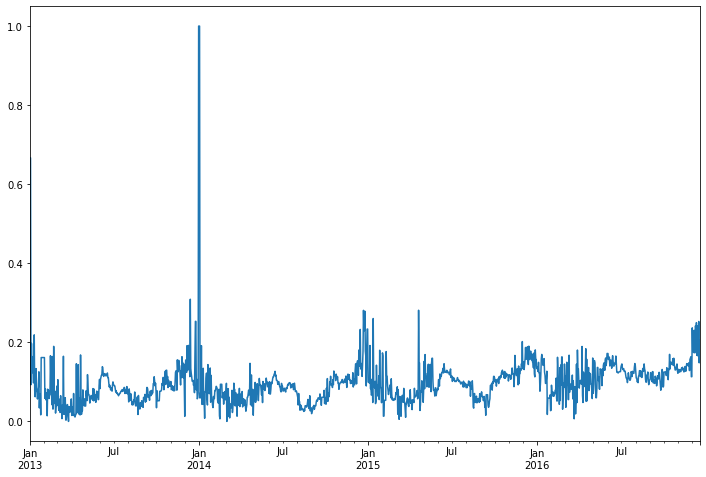

In [100]:
ax = df_train['y'].plot(figsize=(12,8))
plt.show()

**예측 결과 확인**

In [101]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,0.204798,0.139229,0.270199
1,2013-01-02,0.200996,0.136914,0.268139
2,2013-01-03,0.191727,0.126125,0.255696
3,2013-01-04,0.182470,0.121577,0.246512
4,2013-01-05,0.175068,0.103710,0.241317
...,...,...,...,...
1456,2016-12-27,0.249723,0.183572,0.317566
1457,2016-12-28,0.249541,0.176942,0.312618
1458,2016-12-29,0.243815,0.180703,0.313739
1459,2016-12-30,0.237967,0.175339,0.305621


**예측값 시각화**

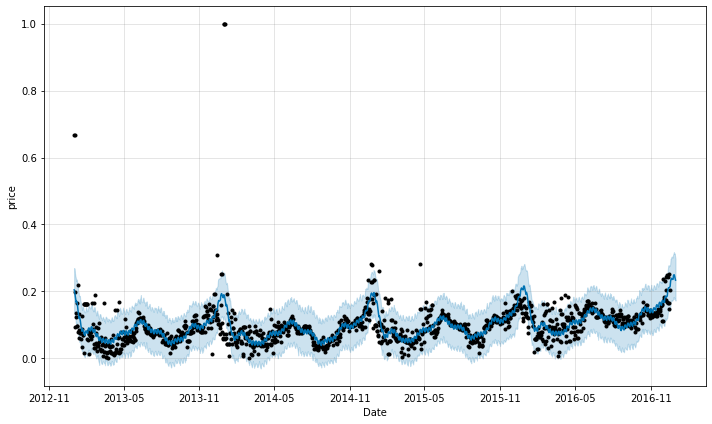

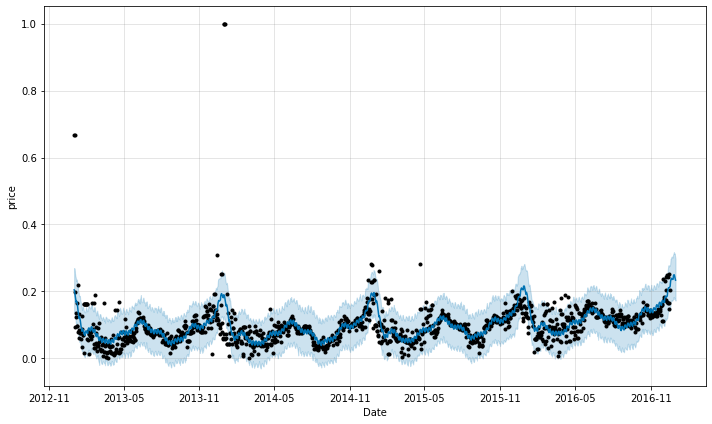

In [102]:
m.plot(forecast, xlabel='Date', ylabel='price')

In [103]:
y_pred = forecast['yhat'][-14:]
y_val = df_val['y']
mean_squared_error(y_pred, y_val)

0.0018623818329433414

val_loss : 0.0018623818329433414


# Result(MSE)
1. LSTM : 0.00290
2. Random Forest : 0.0008831665401987361
3. Prophet : 0.0018623818329433414
